In [1]:
from __future__ import division
import os

import numpy as np
from numpy import pi

import pandas as pd
from numpy import sqrt
from scipy import integrate

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def journal():
    '''
    Appears nearly square. I like this best.
    'figure.figsize': [3.1, 2.6]
    
    Use: plt.tight_layout(pad=0.1, w_pad=0.0, h_pad=0.0)
    plt.xlabel('$E_{iso}$ $(erg)$',labelpad=-1)  
    plt.ylabel('$E^*_{pk}$ $(keV)$',labelpad=-2)
    
    '''
    params = {'backend': 'pdf',
              'axes.labelsize':  10,
              'font.size':       10,
              'legend.fontsize': 8,
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'xtick.direction': 'in',
              'ytick.direction': 'in',
              'text.usetex':     True,
              'figure.figsize': [4,3], #[4,3], #[3.1, 2.6], # [7,6]
              'font.family': 'serif',}
    plt.rcParams.update(params)

In [3]:
journal()

#### All luminosity distance functions must pass results in parsecs.

In [4]:
def LumDist_concordance(redshift, H_knot=None, omega_m=None):
    """
    This is the function we use in our work, but different cosmo constants 
    as well as DL units. 
    """
    z           = redshift
    if H_knot is None:
        H_knot      = 71.               # Hubble Constant.  Units: km/s/Mpc
    if omega_m is None:
        omega_m     = 0.27             # Matter Density.
    omega_l     = 1.0 - omega_m
    
    c           = 2.99792458e5      # SPEED OF LIGHT    Units: km/s
    def Aint(z):
        return (1./(sqrt(((1.+z)*(1.+z)*(1. + omega_m * z))-(z*(2.+ z)*omega_l ))))
    AA      = integrate.quad(Aint, 0.0, z)
    DL_Mpc  = (c * (1. + z) / H_knot) * AA[0]
    DL_pc = DL_Mpc * (1E6) # convert Mpc to pc
    return DL_pc


def LumDist_riess(redshift, H_knot=None, omega_m=None):
    """
    Lower order expansion for dark energy term (w). Equation 14 in Riess et al. 2004. 
    w(z) = w0 + w'z
    """
    z           = redshift
    if H_knot is None:
        H_knot      = 71.               # Hubble Constant.  Units: km/s/Mpc
    if omega_m is None:
        omega_m     = 0.27             # Matter Density.
    omega_l     = 1.0 - omega_m
    c           = 2.99792458e5      # SPEED OF LIGHT    Units: km/s
    w0 = -1.31
    wp = 1.48   # p: prime symbol
    def Aint(z):
        return 1./np.sqrt( ((1.+z)**3)*omega_m + \
                         omega_l*((1.+z)**(3*(1+w0-wp)))*np.exp(3*wp*z) )
    AA      = integrate.quad(Aint, 0.0, z)
    DL_Mpc  = (c * (1. + z) / H_knot) * AA[0]
    DL_pc = DL_Mpc * (1E6) # convert Mpc to pc
    return DL_pc


def LumDist_weylgravity(redshift, H_knot=None):
    """
    Weyl Gravity.
    Equation 237 in Mannheim 2006 paper
    q_knot      = -0.37 or -0.2
    """
    z           = redshift
    if H_knot is None:
        H_knot      = 71.               # Hubble Constant.  Units: km/s/Mpc
    c           = 2.99792458e5      # SPEED OF LIGHT    Units: km/s
    q_knot      = -0.37
    DL_Mpc  = (-c * ((1. + z)**2) / (H_knot * q_knot)) * \
                (1-np.sqrt(1 + q_knot - (q_knot/((1+z)**2))))
    DL_pc = DL_Mpc * (1E6) # convert Mpc to pc
    return DL_pc

# def LumDist_wexpansion_2(redshift):
#     H_knot      = 71               # Hubble Constant.  Units: km/s/Mpc
#     omega_m     = 0.27             # Matter Density.
#     omega_l     = 1.0 - omega_m
#     c          = 2.99792458e5      # SPEED OF LIGHT    Units: km/s
#     w0 = -1.31
#     wa = 

#     z = redshift
#     def Aint(z):
#         return 1./np.sqrt( ((1.+z)**3)*omega_m + \
#                          omega_l*((1.+z)**(3*(1+w0+wa)))*np.exp(-3*wz*z/(1+z)) )
#     AA      = integrate.quad(Aint, 0.0, z)
#     DL_Mpc  = (c * (1. + z) / H_knot) * AA[0]
#     DL_pc = DL_Mpc * (1E6)
#     return DL_pc

    
def distance_modulus(lumdistance):
    return 5*np.log10(lumdistance)-5


def get_moduli(model, redshifts=None, H_knot=None, omega_m=None):
    """
    model : str. 'concord', 'weyl', or 'riess'
                    or 'c', 'w', and 'r'
    
    """
    H0 = H_knot
    OM = omega_m
    if model.startswith('c'):   
        DLs = [LumDist_concordance(redshift=z, H_knot=H0, omega_m=OM) for z in redshifts]
    elif model.startswith('r'):   
        DLs = [LumDist_riess(redshift=z, H_knot=H0, omega_m=OM) for z in redshifts]
    elif model.startswith('w'):   
        DLs = [LumDist_weylgravity(redshift=z, H_knot=H0) for z in redshifts]
    moduli = [distance_modulus(lumdistance=dL) for dL in DLs]
    return moduli

In [5]:
def calc_eiso(fluence, lumdist, redshift):
    flue = fluence
    DL = lumdist 
    z = redshift
    return flue*((4.0*pi*(DL**2))/(1.0+z))

Read Data
---

### 1 keV-10 keV Fluxes, Fluences, and Eisos:  Flux3, Flue3, Eiso3
---
The Eisos in this file were computed with our concordance cosmology.

The errors on flux and fluence in this file are **Margins of Error**

Margins of error can no be logged. Must find the Confidence Interval bounds first and then log those. 

Since we plant to calculate Eiso energies for these errors, we might as well convert them to confidence intervals immediately so that they are easier to work with. 

In [6]:
filename = ('/Users/KimiZ/GRBs2/Sample/'
            'Band_13_GBM+LAT__22_GBMconstrained.txt')

df_ = pd.read_csv(filename, sep='\t')

In [7]:
cols2keep = ['trigger', 'name', 'number', 'z', 't90', 'detector','LATburst'] 

# Make new dataframe with only certain columns
df = pd.DataFrame(df_.loc[:, cols2keep])

# Copy over flux and fluences from 1 keV-10 MeV. 
df['flux'] = df_['Flux3']
df['flux_err_low'] = df_['Flux3']-df_['Flux3_err']  # value - margin of error
df['flux_err_up'] = df_['Flux3']+df_['Flux3_err']   # value + margin of error


df['fluence'] = df_['Flue3']
df['fluence_err_low'] = df_['Flue3']-df_['Flue3_err']  # value - margin of error
df['fluence_err_up'] = df_['Flue3']+df_['Flue3_err']   # value + margin of error

In [8]:
df.loc[:, 'flux':'fluence_err_up']

,flux,flux_err_low,flux_err_up,fluence,fluence_err_low,fluence_err_up
0,1.510120e-06,1.479451e-06,1.540789e-06,0.000095,0.000093,0.000097
1,1.138526e-06,1.113320e-06,1.163731e-06,0.000154,0.000150,0.000157
2,1.289260e-06,1.252148e-06,1.326373e-06,0.000080,0.000077,0.000082
3,1.289040e-05,1.199399e-05,1.378682e-05,0.000012,0.000012,0.000013
4,2.046451e-05,2.030564e-05,2.062338e-05,0.000396,0.000392,0.000399
5,1.297451e-05,1.290484e-05,1.304419e-05,0.000179,0.000178,0.000179
6,2.026665e-06,1.968604e-06,2.084725e-06,0.000041,0.000040,0.000042
7,6.484519e-07,5.840776e-07,7.128262e-07,0.000008,0.000007,0.000009
8,8.423418e-07,8.144667e-07,8.702168e-07,0.000139,0.000135,0.000144
9,4.409283e-06,4.335022e-06,4.483544e-06,0.000033,0.000032,0.000034


Now our errors on flux and fluence are **Confidence Intervals.**

These can now be logged and can be used for computing confidence intervals on Eiso.

In [9]:
#   The luminosity distances of these functions are in parsecs. Need to use pctocm to convert to cm.
# 1 pc = 3.0856775814914E+18 cm
Mpctocm = 3.08567758E24
pctocm = 3.08567758E18

In [10]:
redshifts = df.z.values

In [11]:
# Concordance Cosmology (Lambda CDM)

H_knot = 67.8
omega_m = 0.308
df['DL1'] = np.asarray([LumDist_concordance(redshift=z, H_knot=H_knot, omega_m=omega_m) for z in redshifts])*pctocm

H_knot = 65.0
omega_m = 0.308
df['DL2'] = np.asarray([LumDist_concordance(redshift=z, H_knot=H_knot, omega_m=omega_m) for z in redshifts])*pctocm

H_knot = 75.0
omega_m = 0.308
df['DL3'] = np.asarray([LumDist_concordance(redshift=z, H_knot=H_knot, omega_m=omega_m) for z in redshifts])*pctocm

In [12]:
# Concordance Cosmology (Lambda CDM)
df['eiso1']         = calc_eiso(fluence=df.fluence, lumdist=df['DL1'], redshift=df.z)
df['eiso1_err_low'] = calc_eiso(fluence=df.fluence_err_low, lumdist=df['DL1'], redshift=df.z)
df['eiso1_err_up']  = calc_eiso(fluence=df.fluence_err_up, lumdist=df['DL1'], redshift=df.z)
df['eiso1_err']     = df['eiso1']-df['eiso1_err_low']  # margin of error. Eiso errs should be symmetrical when unlogged

# Concordance Cosmology (Lambda CDM)
df['eiso2']         = calc_eiso(fluence=df.fluence, lumdist=df['DL2'], redshift=df.z)
df['eiso2_err_low'] = calc_eiso(fluence=df.fluence_err_low, lumdist=df['DL2'], redshift=df.z)
df['eiso2_err_up']  = calc_eiso(fluence=df.fluence_err_up, lumdist=df['DL2'], redshift=df.z)
df['eiso2_err']     = df['eiso2']-df['eiso2_err_low']  # margin of error. Eiso errs should be symmetrical when unlogged


# Concordance Cosmology (Lambda CDM)
df['eiso3']         = calc_eiso(fluence=df.fluence, lumdist=df['DL3'], redshift=df.z)
df['eiso3_err_low'] = calc_eiso(fluence=df.fluence_err_low, lumdist=df['DL3'], redshift=df.z)
df['eiso3_err_up']  = calc_eiso(fluence=df.fluence_err_up, lumdist=df['DL3'], redshift=df.z)
df['eiso3_err']     = df['eiso3']-df['eiso3_err_low']  # margin of error. Eiso errs should be symmetrical when unlogged


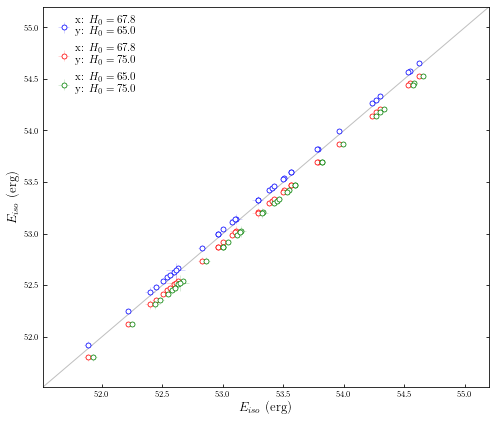

In [13]:
axLims = (51.51, 55.2)

plt.clf()
plt.figure(figsize=(8,7))


xaxis = 'eiso1'
yaxis = 'eiso2'
#pltKwgs = dict(fmt='o', color='blue', ecolor='blue', ms=3, capsize=0, alpha=0.25, label='x: $H_0=67.8$\ny: $H_0=65.0$')
pltKwgs = dict(fmt='o', color='white', ecolor='blue', ms=5, lw=0.6, mec='blue', mew=0.75,
               capsize=0, alpha=1, label='x: $H_0=67.8$\ny: $H_0=65.0$')
x = df[xaxis].apply(np.log10)
y = df[yaxis].apply(np.log10)
xerr = np.asarray([(df[xaxis].apply(np.log10)-df[xaxis+'_err_low'].apply(np.log10)).values, # lower margin of error
                   (df[xaxis+'_err_up'].apply(np.log10)-df[xaxis].apply(np.log10)).values]) # upper margin of error
yerr = np.asarray([(df[yaxis].apply(np.log10)-df[yaxis+'_err_low'].apply(np.log10)).values, # lower margin of error
                   (df[yaxis+'_err_up'].apply(np.log10)-df[yaxis].apply(np.log10)).values]) # upper margin of error
#plt.errorbar(x=x, y=y, yerr=yerr, xerr=xerr, **pltKwgs)
markers, caps, bars = plt.errorbar(x=x, y=y, yerr=yerr, xerr=xerr, **pltKwgs)
[bar.set_alpha(0.25) for bar in bars]
[cap.set_alpha(0.25) for cap in caps]



xaxis = 'eiso1'
yaxis = 'eiso3'
#pltKwgs = dict(fmt='d', color='red', ecolor='red', ms=3, capsize=0, alpha=0.25, label='x: $H_0=67.8$\ny: $H_0=75.0$')
pltKwgs = dict(fmt='o', color='white', ecolor='red', ms=5, lw=0.6, mec='red', mew=0.75,
               capsize=0, alpha=1, label='x: $H_0=67.8$\ny: $H_0=75.0$')
x = df[xaxis].apply(np.log10)
y = df[yaxis].apply(np.log10)
xerr = np.asarray([(df[xaxis].apply(np.log10)-df[xaxis+'_err_low'].apply(np.log10)).values, # lower margin of error
                   (df[xaxis+'_err_up'].apply(np.log10)-df[xaxis].apply(np.log10)).values]) # upper margin of error
yerr = np.asarray([(df[yaxis].apply(np.log10)-df[yaxis+'_err_low'].apply(np.log10)).values, # lower margin of error
                   (df[yaxis+'_err_up'].apply(np.log10)-df[yaxis].apply(np.log10)).values]) # upper margin of error
#plt.errorbar(x=x, y=y, yerr=yerr, xerr=xerr, **pltKwgs)
markers, caps, bars = plt.errorbar(x=x, y=y, yerr=yerr, xerr=xerr, **pltKwgs)
[bar.set_alpha(0.25) for bar in bars]
[cap.set_alpha(0.25) for cap in caps]


xaxis = 'eiso2'
yaxis = 'eiso3'
#pltKwgs = dict(fmt='s', color='green', ecolor='green', ms=3, capsize=0, alpha=0.25, label='x: $H_0=65.0$\ny: $H_0=75.0$')
pltKwgs = dict(fmt='o', color='white', ecolor='green', ms=5, lw=0.6, mec='green', mew=0.75,
               capsize=0, alpha=1, label='x: $H_0=65.0$\ny: $H_0=75.0$')
x = df[xaxis].apply(np.log10)
y = df[yaxis].apply(np.log10)
xerr = np.asarray([(df[xaxis].apply(np.log10)-df[xaxis+'_err_low'].apply(np.log10)).values, # lower margin of error
                   (df[xaxis+'_err_up'].apply(np.log10)-df[xaxis].apply(np.log10)).values]) # upper margin of error
yerr = np.asarray([(df[yaxis].apply(np.log10)-df[yaxis+'_err_low'].apply(np.log10)).values, # lower margin of error
                   (df[yaxis+'_err_up'].apply(np.log10)-df[yaxis].apply(np.log10)).values]) # upper margin of error
#plt.errorbar(x=x, y=y, yerr=yerr, xerr=xerr, **pltKwgs)
markers, caps, bars = plt.errorbar(x=x, y=y, yerr=yerr, xerr=xerr, **pltKwgs)
[bar.set_alpha(0.25) for bar in bars]
[cap.set_alpha(0.25) for cap in caps]


# Plot a line at equal values of x and y 
xlinedata = np.linspace(axLims[0], axLims[1], 10)
ylinedata = 1.0*xlinedata+0
plt.plot(xlinedata, ylinedata, 'k-', lw=1, alpha=0.25) 

plt.xlim(*axLims)
plt.ylim(*axLims)
plt.legend(loc=0, fontsize=11, labelspacing=0.7, handletextpad=0, frameon=False)
plt.xlabel('$E_{iso}$ (erg)', fontsize=13)
plt.ylabel('$E_{iso}$ (erg)', fontsize=13)
plt.show()

In [14]:
df['diff_1v2'] = (df['eiso1'].apply(np.log10) - df['eiso2'].apply(np.log10)).apply(abs)

df['diff_1v3'] = (df['eiso1'].apply(np.log10) - df['eiso3'].apply(np.log10)).apply(abs)

df['diff_2v3'] = (df['eiso2'].apply(np.log10) - df['eiso3'].apply(np.log10)).apply(abs)

In [27]:
sort_by = 'diff_2v3'

kim = df.sort_values(by=sort_by).loc[:, ['z',sort_by]]

In [28]:
plt.clf()

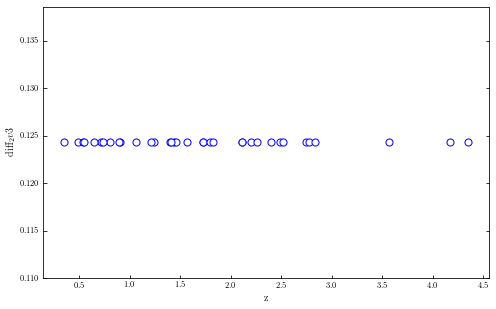

In [29]:
(kim).plot(kind='scatter', x='z', y=sort_by, figsize=(8,5),
                                                        marker='o', s=50, color='white', edgecolor='blue')      

In [30]:
kim

,z,diff_2v3
0,4.3500,0.124296
19,0.4900,0.124296
20,1.3980,0.124296
21,2.1060,0.124296
22,1.4400,0.124296
23,0.8040,0.124296
24,1.7270,0.124296
18,1.2400,0.124296
25,1.4600,0.124296
27,1.7280,0.124296


In [25]:
kim.min()

z           0.347000
diff_1v3    0.087663
dtype: float64

In [26]:
kim.max()

z           4.350000
diff_1v3    0.087663
dtype: float64